## Задача 5: Трек ИИ  

### Команда ProfitGPT
#### Автор ноутбука: Трифонов Никита

Проблема кредитного скоринга является важной составляющей процесса кредитования в банковской сфере. На основе результатов моделей кредитного скоринга, среди прочего, рассчитывается средний уровень вероятности дефолта (Probability of Default — PD). Дефолт возникает, когда заемщик прекращает вносить необходимые платежи по долгу. Это может подвергнуть заемщика судебным искам и ограничить доступ к кредитам в будущем.  

Ваша задача — создать модель, которая будет использоваться для оценки вероятности дефолта заемщика в процессе жизни кредита. В качестве модели предлагаем использовать модель решающего дерева из-за простоты интерпретируемости результатов (особенно, если имеем дело с неглубокими деревьями).  

__Вам необходимо:__  
* Разделить датасет на обучающую и тестовую выборки в соотношении 80:20 с использованием train_test_split.  
* Используя обучающую выборку датасета, обучить модель, которая будет использоваться для оценки вероятности дефолта заемщика в процессе жизни кредита. Акцентируйте внимание на том, какие гиперпараметры были подобраны для модели.  
* Проверить работу модели с использованием тестовой выборки: посмотреть метрику ROC AUC на обучающей и тестовой выборках.   Сильно ли меняется ее качество? Какие признаки получились наиболее важными (feature importance)? Можно ли объяснить именно такое распределение признаков по важности?  
* Визуализировать дерево в Jupyter.


Оформи решение в виде файла формата .ipynb, содержащего код и пояснения к нему. Ответы на вопросы можно оставить в том же Jupyter Notebook. В поле для ответа оставь ссылку на свой ноутбу

### Чтение данных и первичный EDA

#### Описание факторов:  


__Dataset Information__  
This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.  

__Content__  
There are 25 variables:  

ID: ID of each client  
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit  
SEX: Gender (1=male, 2=female)  
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)  
MARRIAGE: Marital status (1=married, 2=single, 3=others)  
AGE: Age in years  
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)  
PAY_2: Repayment status in August, 2005 (scale same as above)  
PAY_3: Repayment status in July, 2005 (scale same as above)  
PAY_4: Repayment status in June, 2005 (scale same as above)  
PAY_5: Repayment status in May, 2005 (scale same as above)  
PAY_6: Repayment status in April, 2005 (scale same as above)  
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)  
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)  
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)  
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)  
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)  
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)  
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)  
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)  
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)  
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)  
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)  
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)  
default.payment.next.month: Default payment (1=yes, 0=no)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('UCI_Credit_Card.csv', delimiter=',')

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df.shape

(30000, 25)

In [5]:
df['ID'].unique().shape

(30000,)

Лики маловероятны. Импользуются уникальные клиенты  

### Делим на трейн и тест  

Для простоты и удобства оценки решения часть необходимых по критериям этапов будут вынесены в отдельные параграфы

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df['default.payment.next.month'].mean()

0.2212

In [8]:
df['ID_cut'] = pd.qcut(df['ID'], 15)

<AxesSubplot:xlabel='ID_cut'>

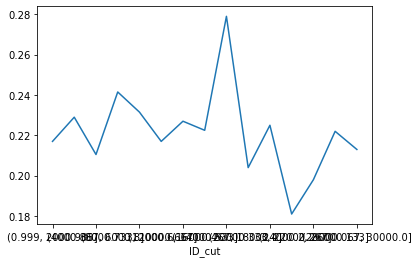

In [9]:
df.groupby('ID_cut').mean()['default.payment.next.month'].plot()

Классы несбалансированы - будем использовать стратификацию по таргету  

Также, отсутсвует временная составляющая в данных (нет поля даты) - выделим случайным образом  

Однако, из графика выше, заметим некоторую склонность и неравномерность от ID - возможно они отранжированны не случайным образом

In [10]:
del df['ID']
del df['ID_cut']

In [11]:
y = df['default.payment.next.month'].copy()
X = df.copy()

In [12]:
del X['default.payment.next.month']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
y_train.mean(), y_test.mean()

(0.22120833333333334, 0.22116666666666668)

### Первичный отбор признаков

Для построения качественной модели отберем релевантные признаки  


Воспользуемся отличным пакетом [FeatureSelector](https://pypi.org/project/feature-selector/)  

Загружаем .py файл в директорию и импортируем необходимые классы  

In [15]:
from feature_selector import FeatureSelector

In [16]:
# не исключаем таргет в данном подходе

train_labels = 'default.payment.next.month'

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[train_labels])

In [17]:
train.shape

(24000, 24)

In [18]:
train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
22788,160000.0,2,2,2,33,2,2,3,2,0,...,164310.0,162681.0,163005.0,15000.0,0.0,0.0,6100.0,12300.0,6100.0,0
29006,150000.0,2,1,2,34,1,-1,-1,-2,-2,...,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0
16950,10000.0,1,2,1,50,1,2,0,0,0,...,8067.0,8227.0,8400.0,2.0,1281.0,1134.0,294.0,305.0,1000.0,0
22280,220000.0,2,1,2,29,0,0,0,0,0,...,218513.0,131660.0,134346.0,9100.0,9000.0,7887.0,4800.0,4900.0,6000.0,1
11346,310000.0,2,1,2,32,1,-2,-1,0,0,...,326.0,-235.0,-235.0,0.0,326.0,0.0,0.0,0.0,1200.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23479,100000.0,2,2,2,31,0,0,0,0,0,...,97486.0,97604.0,97241.0,3309.0,4421.0,5486.0,3400.0,3541.0,3894.0,1
13921,120000.0,2,2,2,24,0,0,0,0,0,...,113948.0,122127.0,121962.0,4200.0,4100.0,4100.0,10000.0,4560.0,0.0,0
3794,120000.0,2,1,2,24,0,0,0,0,0,...,49924.0,33188.0,19826.0,3700.0,2023.0,2016.0,2000.0,1200.0,1000.0,0
27565,360000.0,1,1,1,57,1,-2,-1,-1,-1,...,246.0,-46.0,-46.0,0.0,860.0,246.0,0.0,0.0,0.0,0


In [19]:
# Признаки - в train, метки - в train_labels
fs = FeatureSelector(data = train, labels = train_labels)

In [20]:
fs.identify_missing(missing_threshold = 0.6)

0 features with greater than 0.60 missing values.



In [21]:
fs.missing_stats.head()

,missing_fraction
LIMIT_BAL,0.0
SEX,0.0
PAY_AMT6,0.0
PAY_AMT5,0.0
PAY_AMT4,0.0


In [22]:
fs.identify_collinear(correlation_threshold = 0.75)

9 features with a correlation magnitude greater than 0.75.



C:\Users\lemon\code\Finodays_2023_hack\feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)


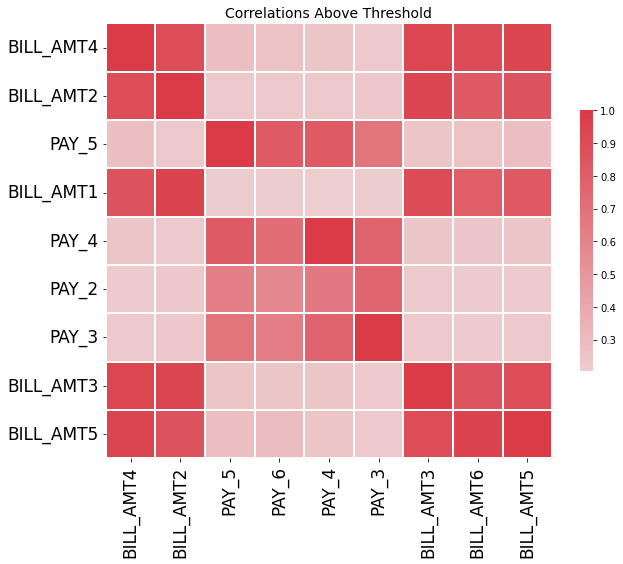

In [23]:
fs.plot_collinear()

In [24]:
# список признаков для удаления
collinear_features = fs.ops['collinear']

# датафрейм коллинеарных признаков
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,PAY_3,PAY_2,0.764913
1,PAY_4,PAY_3,0.775581
2,PAY_5,PAY_4,0.817344
3,PAY_6,PAY_5,0.813662
4,BILL_AMT2,BILL_AMT1,0.951687


In [25]:
train_removed = fs.remove(methods = ['collinear'])

Removed 9 features.


Были удалены скоррелированные признаки по платежам

In [26]:
train_removed.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default.payment.next.month'],
      dtype='object')

Проведем дополнительно однофакторный анализ

In [27]:
train_cols = ['AGE',
 'BILL_AMT1',
 'EDUCATION',
 'LIMIT_BAL',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX']

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
gini_df = pd.DataFrame(columns=train_cols)


for f in train_cols:
    
    value = 2 * roc_auc_score(y_train, train[f]) - 1
    
    gini_df.loc[f] = value
    
    
gini_df = gini_df.iloc[:,0]

In [30]:
gini_df

AGE          0.004641
BILL_AMT1   -0.032349
EDUCATION    0.054791
LIMIT_BAL   -0.246868
MARRIAGE    -0.026776
PAY_0        0.386161
PAY_2        0.280210
PAY_AMT1    -0.225188
PAY_AMT2    -0.209474
PAY_AMT3    -0.196226
PAY_AMT4    -0.172105
PAY_AMT5    -0.161865
PAY_AMT6    -0.170353
SEX         -0.051666
Name: AGE, dtype: float64

In [31]:
corr = train[train_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,AGE,BILL_AMT1,EDUCATION,LIMIT_BAL,MARRIAGE,PAY_0,PAY_2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX
AGE,1.000000,0.056919,0.172803,0.147496,-0.415418,-0.037709,-0.048496,0.027359,0.029715,0.025881,0.024587,0.028001,0.022144,-0.092853
BILL_AMT1,0.056919,1.000000,0.027357,0.284978,-0.025041,0.183453,0.233395,0.138710,0.110272,0.164154,0.157373,0.167950,0.175381,-0.033897
EDUCATION,0.172803,0.027357,1.000000,-0.217312,-0.142974,0.110330,0.126793,-0.037006,-0.027610,-0.040459,-0.044356,-0.038855,-0.033556,0.010333
LIMIT_BAL,0.147496,0.284978,-0.217312,1.000000,-0.111545,-0.270244,-0.298830,0.193856,0.194259,0.210315,0.204857,0.223456,0.216884,0.025523
MARRIAGE,-0.415418,-0.025041,-0.142974,-0.111545,1.000000,0.019579,0.026117,-0.007432,-0.008180,-0.001747,-0.010863,-0.004041,-0.004706,-0.027014
PAY_0,-0.037709,0.183453,0.110330,-0.270244,0.019579,1.000000,0.666701,-0.081504,-0.073977,-0.067580,-0.069714,-0.061757,-0.063112,-0.061918
PAY_2,-0.048496,0.233395,0.126793,-0.298830,0.026117,0.666701,1.000000,-0.085027,-0.060809,-0.054764,-0.050333,-0.039296,-0.040065,-0.072792
PAY_AMT1,0.027359,0.138710,-0.037006,0.193856,-0.007432,-0.081504,-0.085027,1.000000,0.308418,0.260887,0.221885,0.147011,0.202827,0.002164
PAY_AMT2,0.029715,0.110272,-0.027610,0.194259,-0.008180,-0.073977,-0.060809,0.308418,1.000000,0.272804,0.217138,0.146840,0.192102,-0.006340
PAY_AMT3,0.025881,0.164154,-0.040459,0.210315,-0.001747,-0.067580,-0.054764,0.260887,0.272804,1.000000,0.237589,0.143557,0.171257,-0.004974


## Построение базовой модели

In [32]:
train_cols = ['AGE',
 'BILL_AMT1',
 'EDUCATION',
 'LIMIT_BAL',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX']

In [33]:
X_train = X_train[train_cols]
X_test = X_test[train_cols]

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
clf = DecisionTreeClassifier(random_state=0)

In [36]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [37]:
pred_train = clf.predict_proba(X_train)[:, 1]
pred_test = clf.predict_proba(X_test)[:, 1]

In [38]:
print(roc_auc_score(y_train, pred_train))
print(roc_auc_score(y_test, pred_test))

0.9999991232536031
0.6115339592144647


Модель оказалась сильно переобученной.  

Возможные решения:  
* ограничить глубину дерева (тюнинг гиперпараметров)
* ограничить число признаков

In [39]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

In [40]:
clf2 = DecisionTreeClassifier(random_state=0)


# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = {'criterion': criterion,
             'max_depth': max_depth,
             'min_samples_leaf': [1, 2, 3]
             
             }

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf_gs = GridSearchCV(clf2, parameters)

# Fit the grid search
clf_gs.fit(X_train, y_train)

# View The Best Parameters
print('Best Criterion:', clf_gs.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_gs.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', clf_gs.best_estimator_.get_params()['min_samples_leaf'])


# # Use Cross Validation To Evaluate Model
# CV_Result = cross_val_score(clf_gs, X_train, y_train, cv=4, n_jobs=-1)
# print(); print(CV_Result)
# print(); print(CV_Result.mean())
# print(); print(CV_Result.std())   

Best Criterion: gini
Best max_depth: 4
Best min_samples_leaf: 2


In [41]:
pred_train_gs = clf_gs.predict_proba(X_train)[:, 1]
pred_test_gs = clf_gs.predict_proba(X_test)[:, 1]

In [42]:
print(roc_auc_score(y_train, pred_train_gs))
print(roc_auc_score(y_test, pred_test_gs))

0.754693644200329
0.7410797263891996


Наблюдаем заметное уменьшение переобучения и увеличение скора на тестовой выборке

In [43]:
# get importance
importance = clf_gs.best_estimator_.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {train_cols[i]}, Score: %.5f' % (v))

Feature: AGE, Score: 0.00000
Feature: BILL_AMT1, Score: 0.03434
Feature: EDUCATION, Score: 0.00558
Feature: LIMIT_BAL, Score: 0.03512
Feature: MARRIAGE, Score: 0.00000
Feature: PAY_0, Score: 0.72438
Feature: PAY_2, Score: 0.14665
Feature: PAY_AMT1, Score: 0.00000
Feature: PAY_AMT2, Score: 0.00519
Feature: PAY_AMT3, Score: 0.04682
Feature: PAY_AMT4, Score: 0.00193
Feature: PAY_AMT5, Score: 0.00000
Feature: PAY_AMT6, Score: 0.00000
Feature: SEX, Score: 0.00000


Сравним с изначально обученной моделью

In [44]:
# get importance
importance = clf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {train_cols[i]}, Score: %.5f' % (v))

Feature: AGE, Score: 0.08953
Feature: BILL_AMT1, Score: 0.12081
Feature: EDUCATION, Score: 0.02331
Feature: LIMIT_BAL, Score: 0.07163
Feature: MARRIAGE, Score: 0.01448
Feature: PAY_0, Score: 0.16618
Feature: PAY_2, Score: 0.04268
Feature: PAY_AMT1, Score: 0.08215
Feature: PAY_AMT2, Score: 0.07557
Feature: PAY_AMT3, Score: 0.07879
Feature: PAY_AMT4, Score: 0.07200
Feature: PAY_AMT5, Score: 0.07311
Feature: PAY_AMT6, Score: 0.07379
Feature: SEX, Score: 0.01598


Видим что модель с ограниченным числом листов занулила часть признаков, что соответствует экономической логике (присутствуют схожие по смыслу признаки, пол и возраст не является важным) - мзначально модель переобучилась

### Визуализация лучшей модели

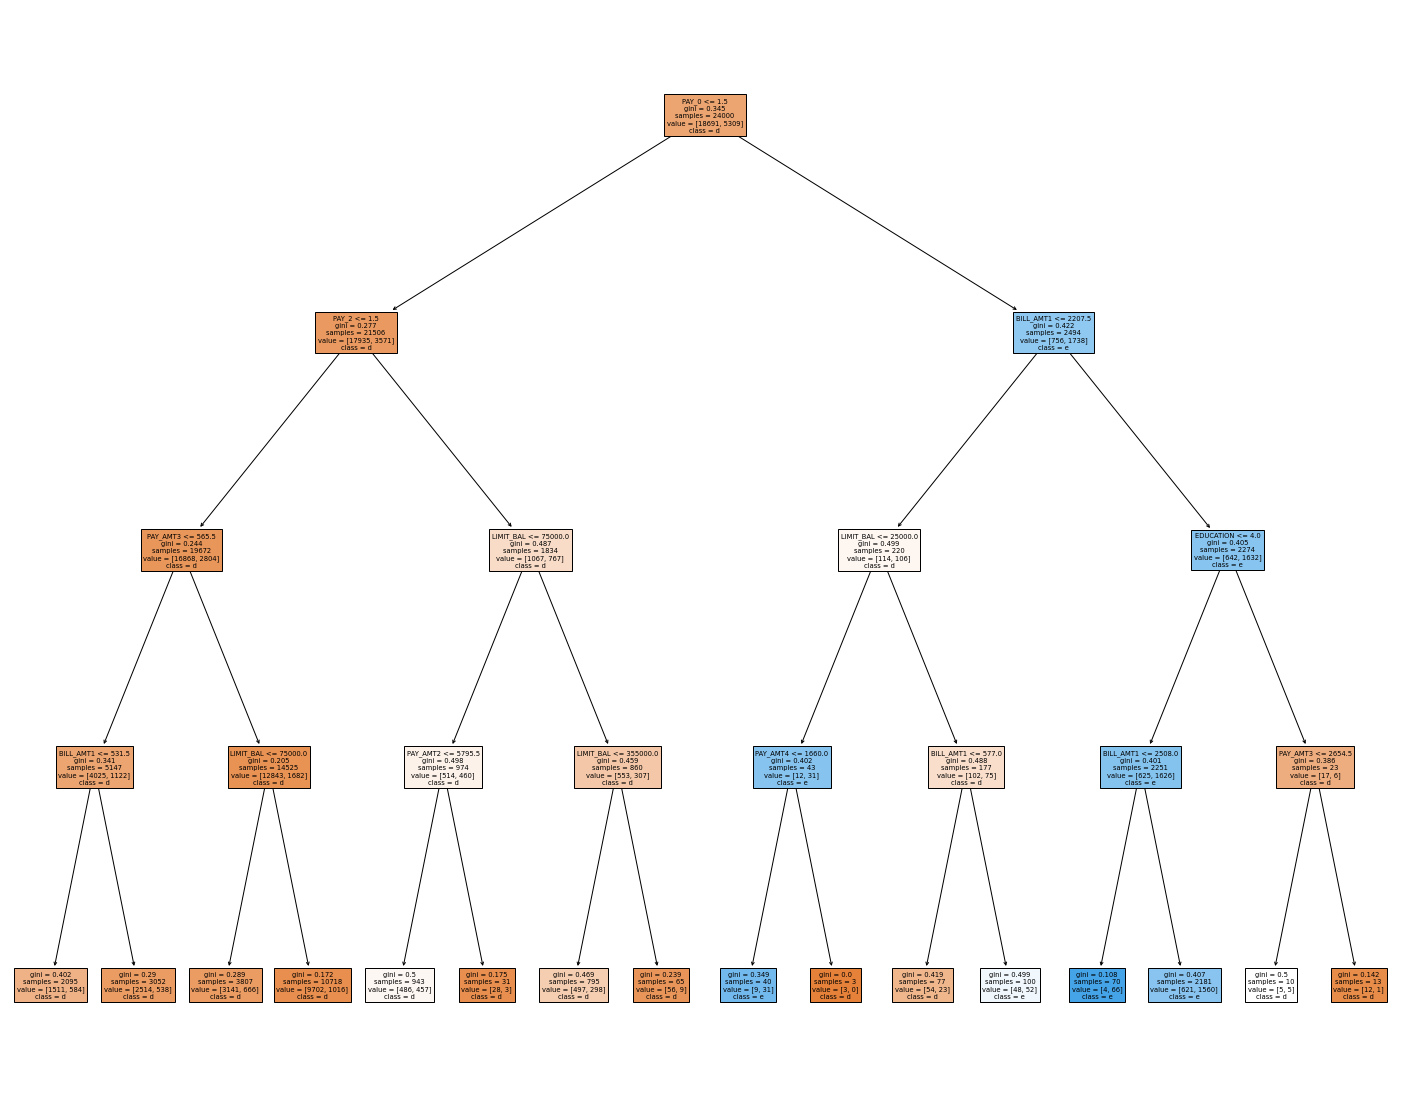

In [45]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_gs.best_estimator_, 
                   feature_names=train_cols,  
                   class_names=train_labels,
                   filled=True)

In [46]:
fig.savefig("decistion_tree_best.png")

In [47]:
text_representation = tree.export_text(clf_gs.best_estimator_, feature_names=train_cols)
print(text_representation)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- PAY_AMT3 <= 565.50
|   |   |   |--- BILL_AMT1 <= 531.50
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT1 >  531.50
|   |   |   |   |--- class: 0
|   |   |--- PAY_AMT3 >  565.50
|   |   |   |--- LIMIT_BAL <= 75000.00
|   |   |   |   |--- class: 0
|   |   |   |--- LIMIT_BAL >  75000.00
|   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- LIMIT_BAL <= 75000.00
|   |   |   |--- PAY_AMT2 <= 5795.50
|   |   |   |   |--- class: 0
|   |   |   |--- PAY_AMT2 >  5795.50
|   |   |   |   |--- class: 0
|   |   |--- LIMIT_BAL >  75000.00
|   |   |   |--- LIMIT_BAL <= 355000.00
|   |   |   |   |--- class: 0
|   |   |   |--- LIMIT_BAL >  355000.00
|   |   |   |   |--- class: 0
|--- PAY_0 >  1.50
|   |--- BILL_AMT1 <= 2207.50
|   |   |--- LIMIT_BAL <= 25000.00
|   |   |   |--- PAY_AMT4 <= 1660.00
|   |   |   |   |--- class: 1
|   |   |   |--- PAY_AMT4 >  1660.00
|   |   |   |   |--- class: 0
|   |   |--- LIMIT_BAL >  25000.00
| 

### Дальнейшие возможные шаги  

* Сгенерировать признаки как отношение, разность платежей и доп отношение платеже к лимиту  
* подбор моделей 
* лучшую фильтрацию признаков - жадные алгоритмы и т.д.
* Калибровка вероятности модели (мжет пригодится для бизнеc-целей, таких как расчет резервов, опрделение отсечкиЮ расчет бизнес-метрик)